# Data Analysis for tiktok trends
## Summary 📝
### 1. Data Understanding 
### 2. Data Cleaning 
### 3. Data Analysis 
#### 3.1 Word Cloud 
#### 3.2 Engagement Trend 
#### 3.3 Top Influential Users 
#### 3.4 Top Influential Hashtags 
#### 3.5 Correlation Matrix 
#### 3.6 Bivariate Analysis 
#### 3.7 Multivariate Analysis 

# 1. Data Understanding 📊

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import warnings
import plotly.figure_factory as ff

In [80]:
# Load data
df = pd.read_csv("/kaggle/input/tiktok-trending/tiktok_trending_final.csv")

In [81]:
# showing first rows of dataset
df.head()

,url,views,likes,shares,comments_count,hashtags,date_posted
0,https://www.tiktok.com/@walidsabbagh/video/746...,200700,200700.0,8483.0,0.0,NaN,10-02-2025
1,https://www.tiktok.com/@sol__is/video/74604919...,61800,61800.0,7289.0,2069.0,#عمر_بن_عطية,13-02-2025
2,https://www.tiktok.com/@hssan_hachani_com/vide...,25200,25200.0,6983.0,1058.0,"#smartphone, #hachanicom",13-02-2025
3,https://www.tiktok.com/@houssem_lass/video/746...,19800,19800.0,1294.0,785.0,NaN,08-02-2025
4,https://www.tiktok.com/@gooba_off/video/746937...,359000,359100.0,179300.0,7776.0,"#foryou, #fyp, #viral, #السعودية, #مصر, #مغرب,...",10-02-2025


In [82]:
# Display basic info
print("Dataset Overview:")
print(df.info())
print(df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   url             60 non-null     object 
 1   views           60 non-null     int64  
 2   likes           59 non-null     float64
 3   shares          59 non-null     float64
 4   comments_count  59 non-null     float64
 5   hashtags        37 non-null     object 
 6   date_posted     60 non-null     object 
dtypes: float64(3), int64(1), object(3)
memory usage: 3.4+ KB
None
               views          likes         shares  comments_count
count      60.000000      59.000000      59.000000       59.000000
mean    73224.250000   74122.966102   16803.203390     1526.457627
std    118726.416874  119550.980103   51705.945445     2788.381877
min      7234.000000    7234.000000     160.000000        0.000000
25%     21950.000000   22350.000000    1038.000000      231.500000
50%   

# 2. Data Cleaning 🧹

In [83]:
# Check for missing values
df.isnull().sum()


url                0
views              0
likes              1
shares             1
comments_count     1
hashtags          23
date_posted        0
dtype: int64

In [84]:
# Handle missing values
df.dropna(inplace=True)
df.isnull().sum()

url               0
views             0
likes             0
shares            0
comments_count    0
hashtags          0
date_posted       0
dtype: int64

# 3. Data Analysis 🔍
## 3.1 Word Cloud 📝

In [85]:
df['total_engagement'] = df['likes'] + df['shares'] + df['comments_count']


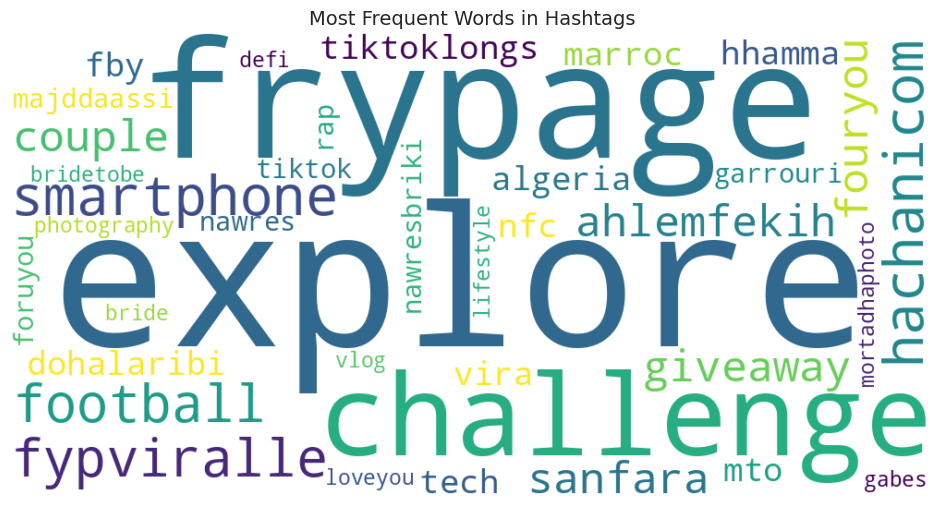

In [86]:
# Word Cloud for Most Frequent Words

import re
from wordcloud import STOPWORDS

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z#\s]', '', text)  # Remove special characters & numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

def generate_wordcloud(text_column):
    text = ' '.join(df[text_column].dropna().astype(str).apply(clean_text))
    
    stopwords = set(STOPWORDS)
    stopwords.update(["foryoupage", "fyp", "foryou", "viral"])  # Add frequent redundant words

    wordcloud = WordCloud(width=1000, height=500, background_color='white', 
                          stopwords=stopwords, colormap='viridis', max_words=100).generate(text)

    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Most Frequent Words in {text_column.capitalize()}", fontsize=14)
    plt.show()

generate_wordcloud('hashtags')


## 3.2 Engagement Trend over time 📅

In [96]:
# Convert 'date_posted' to datetime format
df['date_posted'] = pd.to_datetime(df['date_posted'])

# Aggregate total engagement per day
engagement_trend = df.groupby('date_posted')['total_engagement'].sum().reset_index()

# Create an interactive time series plot
fig = px.line(
    engagement_trend, 
    x='date_posted', 
    y='total_engagement', 
    title='📊 Engagement Trend Over Time',
    markers=True
)

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Total Engagement')
fig.show()


In [95]:
# Ensure date_posted is in datetime format
df['date_posted'] = pd.to_datetime(df['date_posted'])

# Aggregate engagement metrics by date
df_grouped = df.groupby('date_posted').sum().reset_index()

# Plot engagement trends over time
engagement_columns = ['likes', 'shares', 'comments_count', 'views']

for col in engagement_columns:
    fig = px.line(df_grouped, x='date_posted', y=col, title=f' 📊 Time Series Distribution of {col}', markers=True)
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text=col)
    fig.show()

warnings.filterwarnings('ignore')

## 3.3 Top Influential Users 👥

In [89]:
import re

# Ensure 'total_engagement' is created
df['total_engagement'] = df['likes'] + df['shares'] + df['comments_count']

# Extract username from URL
def extract_username(url):
    match = re.search(r'tiktok\.com/@([\w\.]+)', str(url))  # Extract username after '@'
    return match.group(1) if match else 'Unknown'  # Return username or 'Unknown' if not found

# Apply function to create 'username' column
df['username'] = df['url'].apply(extract_username)

# Aggregate engagement metrics by user
top_users = df.groupby('username')['total_engagement'].sum().reset_index()

# Get top 10 most influential users
top_users = top_users.sort_values(by='total_engagement', ascending=False).head(10)

# Plot the data
fig = px.bar(top_users, x='username', y='total_engagement', title='📊 Top 10 Influential Users')
fig.update_xaxes(title_text='Username')
fig.update_yaxes(title_text='Total Engagement')
fig.show()


## 3.4 Top Influential Hashtags #️⃣

In [90]:
from collections import Counter

# Ensure 'total_engagement' is calculated
df['total_engagement'] = df['likes'] + df['shares'] + df['comments_count']

# Expand the hashtags into individual rows
df_exploded = df.assign(hashtags=df['hashtags'].str.split()).explode('hashtags')

# Remove any missing or empty hashtags
df_exploded = df_exploded.dropna(subset=['hashtags'])

# Aggregate engagement metrics by hashtag
top_hashtags = df_exploded.groupby('hashtags')['total_engagement'].sum().reset_index()

# Get the top 10 most influential hashtags
top_hashtags = top_hashtags.sort_values(by='total_engagement', ascending=False).head(10)

# Plot the data
fig = px.bar(top_hashtags, x='hashtags', y='total_engagement', title='Top 10 Influential Hashtags')
fig.update_xaxes(title_text='Hashtags')
fig.update_yaxes(title_text='Total Engagement')
fig.show()


## 3.5 Correlation Matrix 🔗

In [93]:
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff


# ✅ Ensure 'total_engagement' exists
if 'total_engagement' not in df.columns:
    df['total_engagement'] = df['likes'] + df['shares'] + df['comments_count']

# ✅ Select numerical engagement metrics
engagement_metrics = df[['likes', 'shares', 'comments_count', 'views', 'total_engagement']]

# **📊 1. Interactive Correlation Heatmap with Purple Shades**
corr_matrix = engagement_metrics.corr().round(2)
heatmap = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    colorscale="Purples",  # 🔥 Changed from 'Blues' to 'Purples'
    showscale=True
)
heatmap.update_layout(title="🔍 TikTok Engagement Metrics Correlation Heatmap (Purple Theme)")
heatmap.show()

## 3.6 Bivariate Analysis ⚖️

In [100]:
# ✅ Ensure 'total_engagement' exists
if 'total_engagement' not in df.columns:
    df['total_engagement'] = df['likes'] + df['shares'] + df['comments_count']

### **📊 1. Bi-Variate Analysis (Scatter Plots)**

# ✅ Scatter Plot: Views vs Likes
fig1 = px.scatter(df, x='views', y='likes', color='total_engagement',
                  title="💡 Views vs Likes",
                  labels={"views": "Views", "likes": "Likes", "total_engagement": "Total Engagement"},
                  trendline="ols")  # Ordinary Least Squares (Regression Line)
fig1.show()

# ✅ Scatter Plot: Comments vs Shares
fig2 = px.scatter(df, x='comments_count', y='shares', color='total_engagement',
                  title="💬 Comments vs Shares",
                  labels={"comments_count": "Comments", "shares": "Shares", "total_engagement": "Total Engagement"},
                  trendline="ols")
fig2.show()

# ✅ Scatter Plot: Likes vs Shares
fig3 = px.scatter(df, x='likes', y='shares', color='total_engagement',
                  title="📊 Likes vs Shares",
                  labels={"likes": "Likes", "shares": "Shares", "total_engagement": "Total Engagement"},
                  trendline="ols")
fig3.show()




## 3.7 Multivariate Analysis 📐

In [101]:

### **📊 2. Multi-Variate Analysis**

# ✅ 3D Scatter Plot: Views, Likes, and Shares
fig4 = px.scatter_3d(df, x='views', y='likes', z='shares', color='total_engagement',
                      title="📊 3D Engagement Analysis: Views, Likes & Shares",
                      labels={"views": "Views", "likes": "Likes", "shares": "Shares", "total_engagement": "Total Engagement"})
fig4.show()
# ✅ Parallel Coordinates Plot: Multi-Feature Comparison
fig5 = px.parallel_coordinates(df, dimensions=['views', 'likes', 'shares', 'comments_count', 'total_engagement'],
                               color=df['total_engagement'],
                               color_continuous_scale=px.colors.sequential.Purples,  # ✅ Fixed!
                               title="📌 Multi-Feature Comparison: TikTok Engagement Trends")
fig5.show()
